Copyright 2019 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [1]:
# !git clone https://github.com/google-research/google-research.git

In [1]:
import sys
import os

# sys.path.append('./google-research')
!export PYTHONPATH=$HOME/RT-Thread/WakeUp-Xiaorui

# Examples of streaming and non streaming inference with TF/TFlite

## Imports

In [6]:
# TF streaming
from kws_streaming.models import models
from kws_streaming.layers.modes import Modes
from kws_streaming.models import model_params
from kws_streaming.train import model_flags
from kws_streaming.train import test
from kws_streaming.models import utils
from kws_streaming import data

In [7]:
import tensorflow as tf
from tensorflow.python.ops import io_ops
import numpy as np
import tensorflow.compat.v1 as tf1
import logging
tf1.disable_eager_execution()

In [8]:
config = tf1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf1.Session(config=config)

In [9]:
# general imports
import matplotlib.pyplot as plt
import os
import json
import numpy as np
import scipy as scipy
import scipy.io.wavfile as wav
import scipy.signal

In [10]:
tf.__version__

'2.3.0-dev20200515'

In [11]:
tf1.reset_default_graph()
sess = tf1.Session()
tf1.keras.backend.set_session(sess)
tf1.keras.backend.set_learning_phase(0)

Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


## Load wav file

In [12]:
def waveread_as_pcm16(filename):
  """Read in audio data from a wav file.  Return d, sr."""
  with tf.io.gfile.GFile(filename, 'rb') as file_handle:
    samplerate, wave_data = wav.read(file_handle)
  # Read in wav file.
  return wave_data, samplerate

def wavread_as_float(filename, target_sample_rate=16000):
  """Read in audio data from a wav file.  Return d, sr."""
  wave_data, samplerate = waveread_as_pcm16(filename)
  desired_length = int(
      round(float(len(wave_data)) / samplerate * target_sample_rate))
  wave_data = scipy.signal.resample(wave_data, desired_length)

  # Normalize short ints to floats in range [-1..1).
  data = np.array(wave_data, np.float32) / 32768.0
  return data, target_sample_rate

In [13]:
# set PATH to data sets (for example to speech commands V2):
# it can be downloaded from
# https://storage.googleapis.com/download.tensorflow.org/data/speech_commands_v0.02.tar.gz
# if you run 00_check-data.ipynb then data2 should be located in the current folder

# current_dir = os.getcwd()
# DATA_PATH = os.path.join(current_dir, "data2/")
DATA_PATH = "/home/lebhoryi/RT-Thread/WakeUp-Xiaorui/data"

In [14]:
# # Set path to wav file for testing.
# wav_file = os.path.join(DATA_PATH, "left/012187a4_nohash_0.wav")
wav_file = "/home/lebhoryi/RT-Thread/WakeUp-Xiaorui/local_data/test_wav/xrxr/0.wav"

# read audio file
wav_data, samplerate = wavread_as_float(wav_file)
print(wav_data.shape)

(16000,)


In [15]:
assert samplerate == 16000
# sound.Play(wav_data, samplerate)

```python
# for simple test instead of reading wav - just generate cos
# samplerate = 16000
# wav_data = np.cos(2.0*np.pi*8.0*np.arange(samplerate)/samplerate)
```

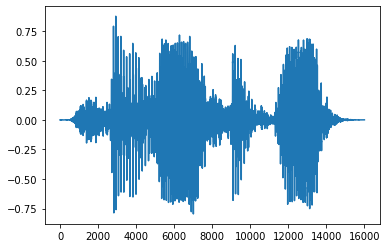

In [11]:
plt.plot(wav_data)
plt.show()

## Prepare batched model

```python
# Set path to model weights and model parameters models trained on data set V2 can be downloaded from
# https://storage.googleapis.com/kws_models/models2.zip
# or from https://storage.googleapis.com/kws_models/models2_30k.zip
MODEL_URL = "https://storage.googleapis.com/kws_models/models2_30k.zip"
base_name = os.path.basename(MODEL_URL)
MODELS_PATH = os.getcwd()
base_name
```

```python
# it can take some time to download 2.3GB. After unpacking total size is 5.4GB
arch_file_name = os.path.join(MODELS_PATH, base_name)
if not os.path.isfile(arch_file_name):
  # download data
  if sys.version_info >= (2, 5):
    file_path, _ = urllib.request.urlretrieve(MODEL_URL, arch_file_name)
  else:
    file_path, _ = urllib.urlretrieve(MODEL_URL, arch_file_name)
  # unpack it
  file_name, file_extension = os.path.splitext(base_name)
  with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall(MODELS_PATH)
    
train_dir = os.path.join(MODELS_PATH, file_name, 'mobilenet')
```

In [12]:
train_dir = '../train_model/cnn'

In [145]:
# load command line command flags which were use for model creation/training
from argparse import Namespace

with tf.compat.v1.gfile.Open(os.path.join(train_dir, 'flags.txt'), 'r') as fd:
  flags_txt = fd.read()
flags = eval(fd.read())
type(flags)

argparse.Namespace

In [14]:
# below is another way of reading flags - through json
# with tf.compat.v1.gfile.Open(os.path.join(train_dir, 'flags.json'), 'r') as fd:
#   flags_json = json.load(fd)

# class DictStruct(object):
#   def __init__(self, **entries):
#     self.__dict__.update(entries)

# flags = DictStruct(**flags_json)


In [147]:
flags.data_dir = DATA_PATH

In [120]:
# pad input audio with zeros, so that audio len = flags.desired_samples
padded_wav = np.pad(wav_data, (0, flags.desired_samples-len(wav_data)), 'constant')

input_data = np.expand_dims(padded_wav, 0)
input_data.shape

(1, 16000)

In [148]:
# prepare mapping of index to word
audio_processor = data.input_data.AudioProcessor(flags)
index_to_label = {}

# labels used for training
for word in audio_processor.word_to_index.keys():
  if audio_processor.word_to_index[word] == data.input_data.SILENCE_INDEX:
    index_to_label[audio_processor.word_to_index[word]] = data.input_data.SILENCE_LABEL
  elif audio_processor.word_to_index[word] == data.input_data.UNKNOWN_WORD_INDEX:
    index_to_label[audio_processor.word_to_index[word]] = data.input_data.UNKNOWN_WORD_LABEL
  else:
    index_to_label[audio_processor.word_to_index[word]] = word
    

# training labels
index_to_label

{1: '_unknown_',
 5: 'down',
 12: 'nihaoxr',
 10: 'stop',
 9: 'off',
 11: 'go',
 3: 'no',
 6: 'left',
 8: 'on',
 13: 'xrxr',
 2: 'yes',
 7: 'right',
 4: 'up',
 0: '_silence_'}

In [ ]:
# we can create a dummy model
# flags = model_params.HOTWORD_MODEL_PARAMS['gru']
# flags = model_flags.update_flags(flags)

In [18]:
# create model with flag's parameters
model_non_stream_batch = models.MODELS[flags.model_name](flags)

# load model's weights
weights_name = 'best_weights'
model_non_stream_batch.load_weights(os.path.join(train_dir, weights_name))

In [19]:
model_non_stream_batch.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(100, 25, 20)]           0         
_________________________________________________________________
tf_op_layer_ExpandDims (Tens [(100, 25, 20, 1)]        0         
_________________________________________________________________
stream (Stream)              (100, 23, 18, 64)         640       
_________________________________________________________________
stream_1 (Stream)            (100, 19, 16, 64)         61504     
_________________________________________________________________
stream_2 (Stream)            (100, 15, 14, 64)         61504     
_________________________________________________________________
stream_3 (Stream)            (100, 11, 12, 64)         61504     
_________________________________________________________________
stream_4 (Stream)            (100, 7, 11, 128)        

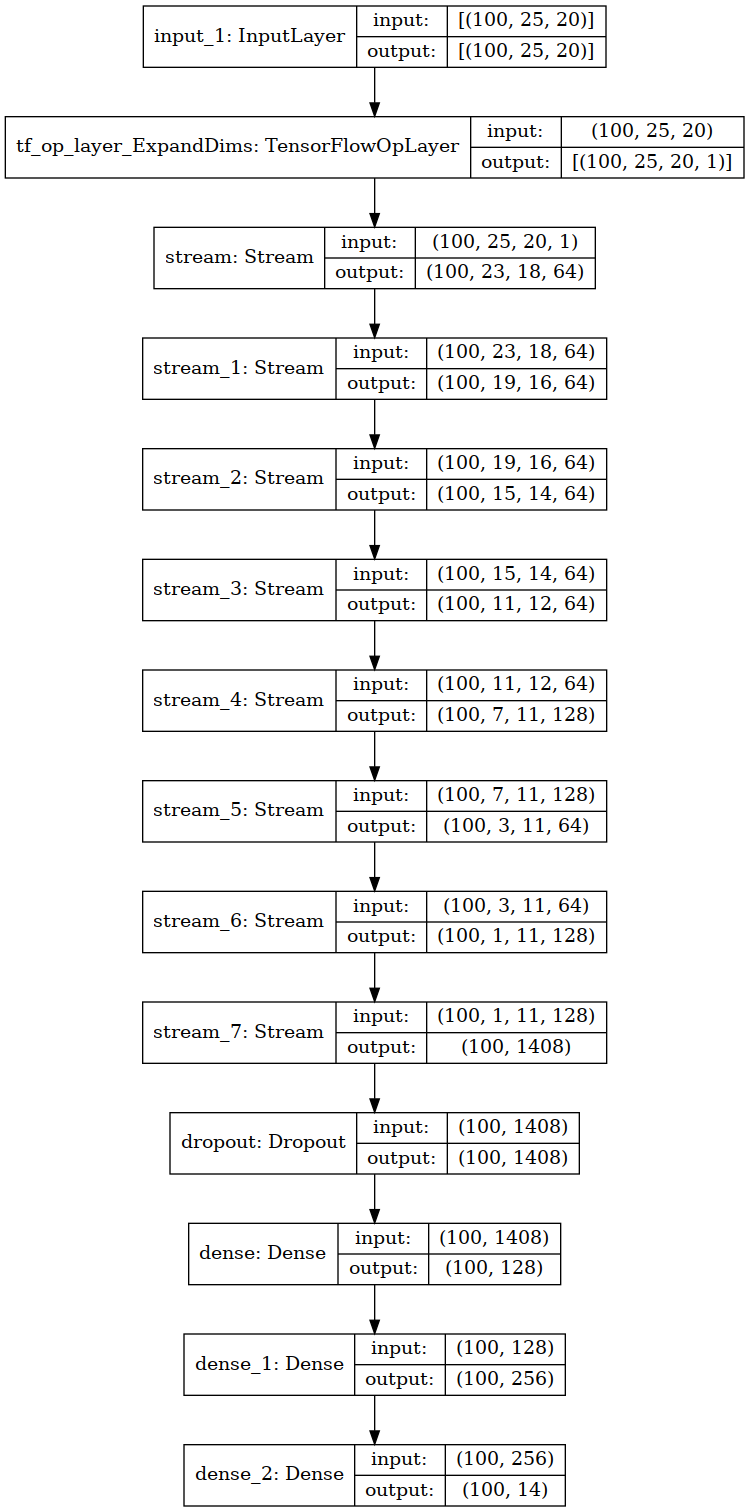

In [20]:
tf.keras.utils.plot_model(
    model_non_stream_batch,
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True)

## Run inference with TF

### TF Run non streaming inference

In [21]:
# convert model to inference mode with batch one
inference_batch_size = 1
tf.keras.backend.set_learning_phase(0)
flags.batch_size = inference_batch_size  # set batch size

model_non_stream = utils.to_streaming_inference(model_non_stream_batch, flags, Modes.NON_STREAM_INFERENCE)
#model_non_stream.summary()

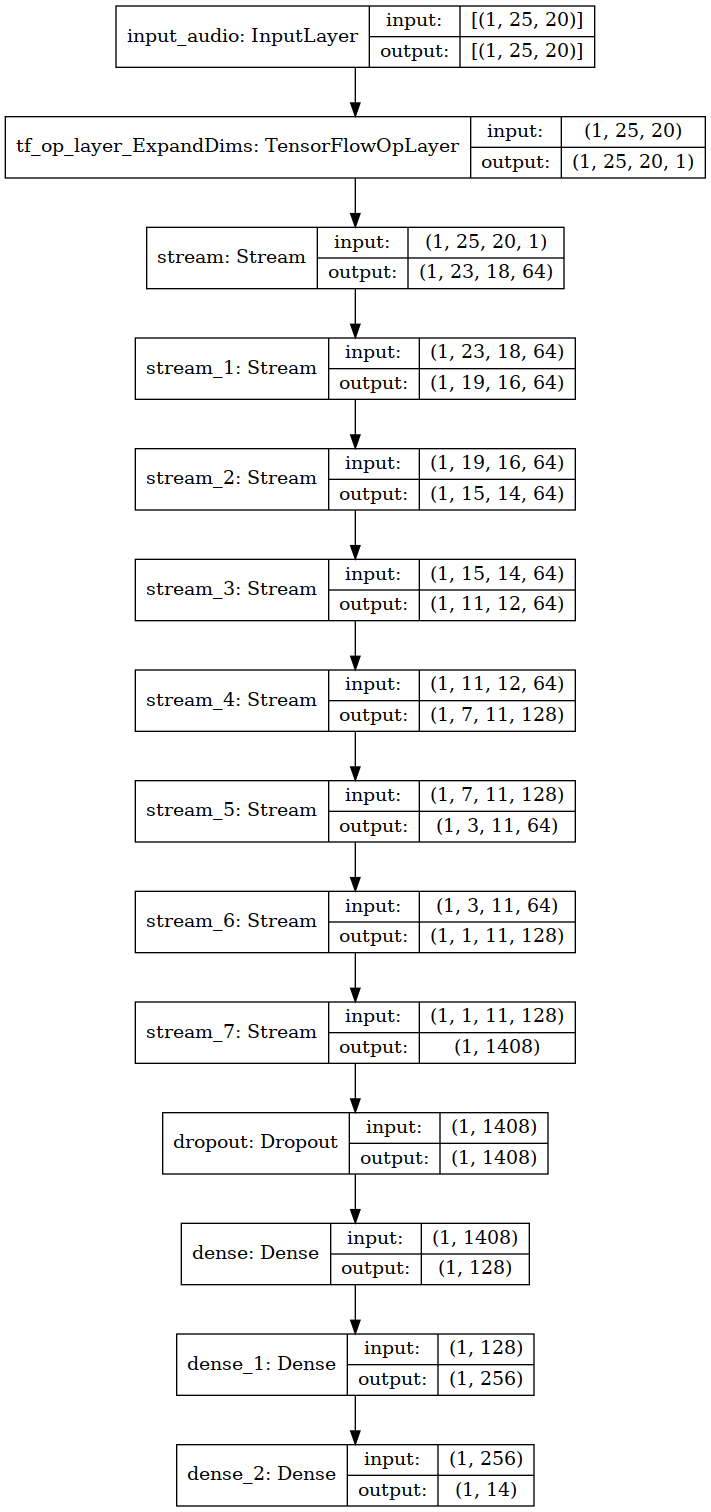

In [22]:
tf.keras.utils.plot_model(
    model_non_stream,
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True)

In [127]:
import tensorflow as tf
from tensorflow.python.ops import gen_audio_ops as audio_ops
from tensorflow.python.ops import io_ops

if flags.preprocess == 'mfcc':
    wav_loader = io_ops.read_file(wav_file)
    wav_decoder = tf.audio.decode_wav(wav_loader, desired_channels=1, 
                                      desired_samples=16000)
    # Run the spectrogram and MFCC ops to get a 2D audio: Short-time FFTs
    # background_clamp dims: [time, channels]
    spectrogram = audio_ops.audio_spectrogram(
        wav_decoder.audio,
        window_size=flags.window_size_samples,
        stride=flags.window_stride_samples,
        magnitude_squared=flags.fft_magnitude_squared)
    # spectrogram: [channels/batch, frames, fft_feature]

    # extract mfcc features from spectrogram by audio_ops.mfcc:
    # 1 Input is spectrogram frames.
    # 2 Weighted spectrogram into bands using a triangular mel filterbank
    # 3 Logarithmic scaling
    # 4 Discrete cosine transform (DCT), return lowest dct_coefficient_count
    mfcc = audio_ops.mfcc(
        spectrogram=spectrogram,
        sample_rate=flags.sample_rate,
        upper_frequency_limit=flags.mel_upper_edge_hertz,
        lower_frequency_limit=flags.mel_lower_edge_hertz,
        filterbank_channel_count=flags.mel_num_bins,
        dct_coefficient_count=flags.dct_num_features)
    # mfcc: [channels/batch, frames, dct_coefficient_count]
    # remove channel dim
#     input_data = tf.squeeze(mfcc, axis=0)
    
    input_data = mfcc

In [149]:
predictions = model_non_stream.predict(input_data, steps=1)
predicted_labels = np.argmax(predictions, axis=1)

In [150]:
predicted_labels

array([13])

In [61]:
index_to_label[predicted_labels[0]]

'xrxr'

### TF Run streaming inference with internal state

In [152]:
# convert model to streaming mode
flags.batch_size = inference_batch_size  # set batch size

model_stream = utils.to_streaming_inference(model_non_stream_batch, flags, Modes.STREAM_INTERNAL_STATE_INFERENCE)
model_stream.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_audio (InputLayer)     [(1, 1, 20)]              0         
_________________________________________________________________
tf_op_layer_ExpandDims (Tens (1, 1, 20, 1)             0         
_________________________________________________________________
stream (Stream)              (1, 1, 18, 64)            700       
_________________________________________________________________
stream_1 (Stream)            (1, 1, 16, 64)            67264     
_________________________________________________________________
stream_2 (Stream)            (1, 1, 14, 64)            66624     
_________________________________________________________________
stream_3 (Stream)            (1, 1, 12, 64)            65984     
_________________________________________________________________
stream_4 (Stream)            (1, 1, 11, 128)          

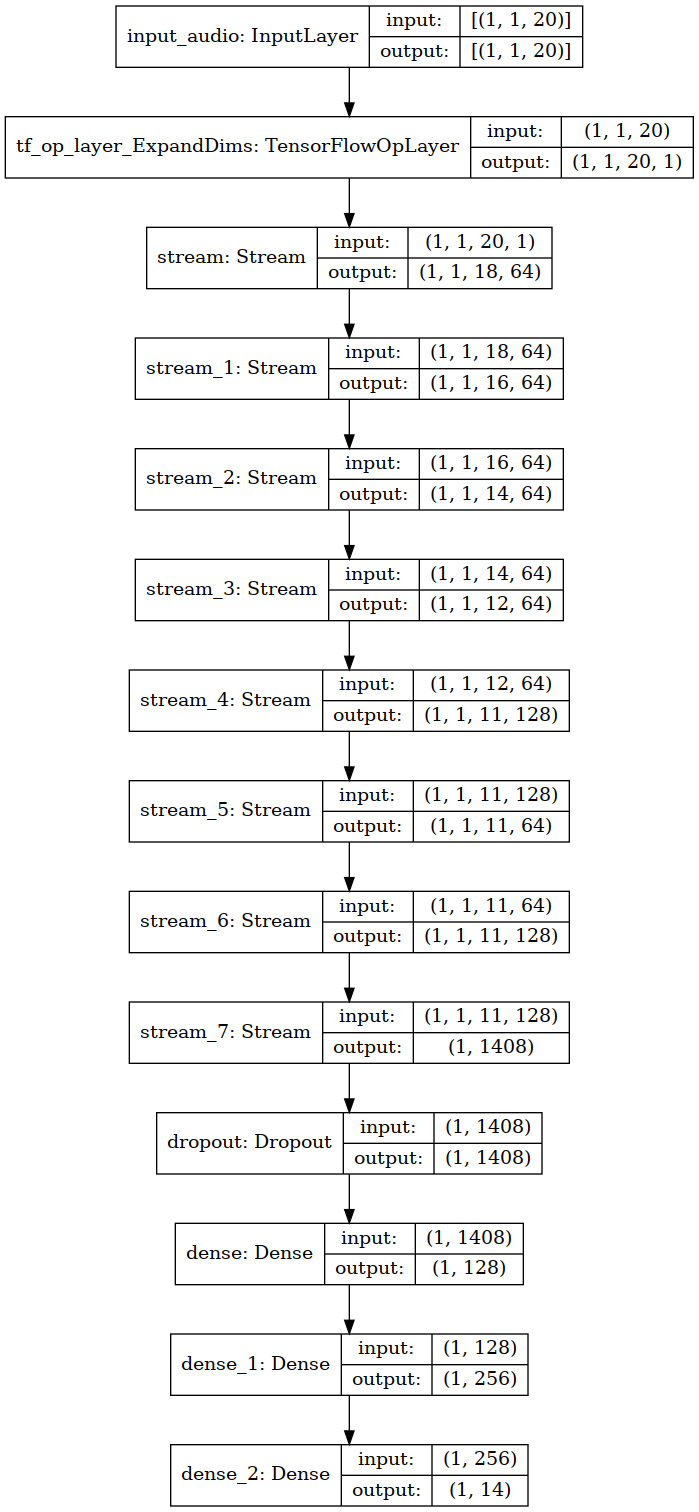

In [74]:
tf.keras.utils.plot_model(
    model_stream,
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True)

In [83]:
# run streaming inference
start = 0
end = flags.window_stride_samples if flags.preprocess not in {'mfcc', 'micro'} else 1
# print(end)
    
while end <= input_data.shape[1]:
  stream_update = input_data[:, start:end, :]
  print(stream_update)

  # get new frame from stream of data
  stream_output_prediction = model_stream.predict(stream_update, steps=1)
  stream_output_arg = np.argmax(stream_output_prediction)
  print(stream_output_arg)

  # update indexes of streamed updates
  start = end
  end = start + flags.window_stride_samples if flags.preprocess not in {'mfcc', 'micro'} else start+1

stream_output_arg

Tensor("strided_slice_4:0", shape=(1, 1, 20), dtype=float32)
5
Tensor("strided_slice_5:0", shape=(1, 1, 20), dtype=float32)
5
Tensor("strided_slice_6:0", shape=(1, 1, 20), dtype=float32)
2
Tensor("strided_slice_7:0", shape=(1, 1, 20), dtype=float32)
2
Tensor("strided_slice_8:0", shape=(1, 1, 20), dtype=float32)
2
Tensor("strided_slice_9:0", shape=(1, 1, 20), dtype=float32)
10
Tensor("strided_slice_10:0", shape=(1, 1, 20), dtype=float32)
10
Tensor("strided_slice_11:0", shape=(1, 1, 20), dtype=float32)
10
Tensor("strided_slice_12:0", shape=(1, 1, 20), dtype=float32)
10
Tensor("strided_slice_13:0", shape=(1, 1, 20), dtype=float32)
1
Tensor("strided_slice_14:0", shape=(1, 1, 20), dtype=float32)
1
Tensor("strided_slice_15:0", shape=(1, 1, 20), dtype=float32)
1
Tensor("strided_slice_16:0", shape=(1, 1, 20), dtype=float32)
1
Tensor("strided_slice_17:0", shape=(1, 1, 20), dtype=float32)
1
Tensor("strided_slice_18:0", shape=(1, 1, 20), dtype=float32)
1
Tensor("strided_slice_19:0", shape=(1, 1, 

13

In [84]:
index_to_label[stream_output_arg]

'xrxr'

### TF Run streaming inference with external state

In [151]:
# convert model to streaming mode
flags.batch_size = inference_batch_size  # set batch size

model_stream = utils.to_streaming_inference(model_non_stream_batch, flags, Modes.STREAM_EXTERNAL_STATE_INFERENCE)
model_stream.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_audio (InputLayer)        [(1, 1, 20)]         0                                            
__________________________________________________________________________________________________
tf_op_layer_ExpandDims (TensorF (1, 1, 20, 1)        0           input_audio[0][0]                
__________________________________________________________________________________________________
stream (Stream)                 (1, 1, 18, 64)       640         tf_op_layer_ExpandDims[0][0]     
__________________________________________________________________________________________________
stream_1 (Stream)               (1, 1, 16, 64)       61504       stream[0][0]                     
_______________________________________________________________________________________

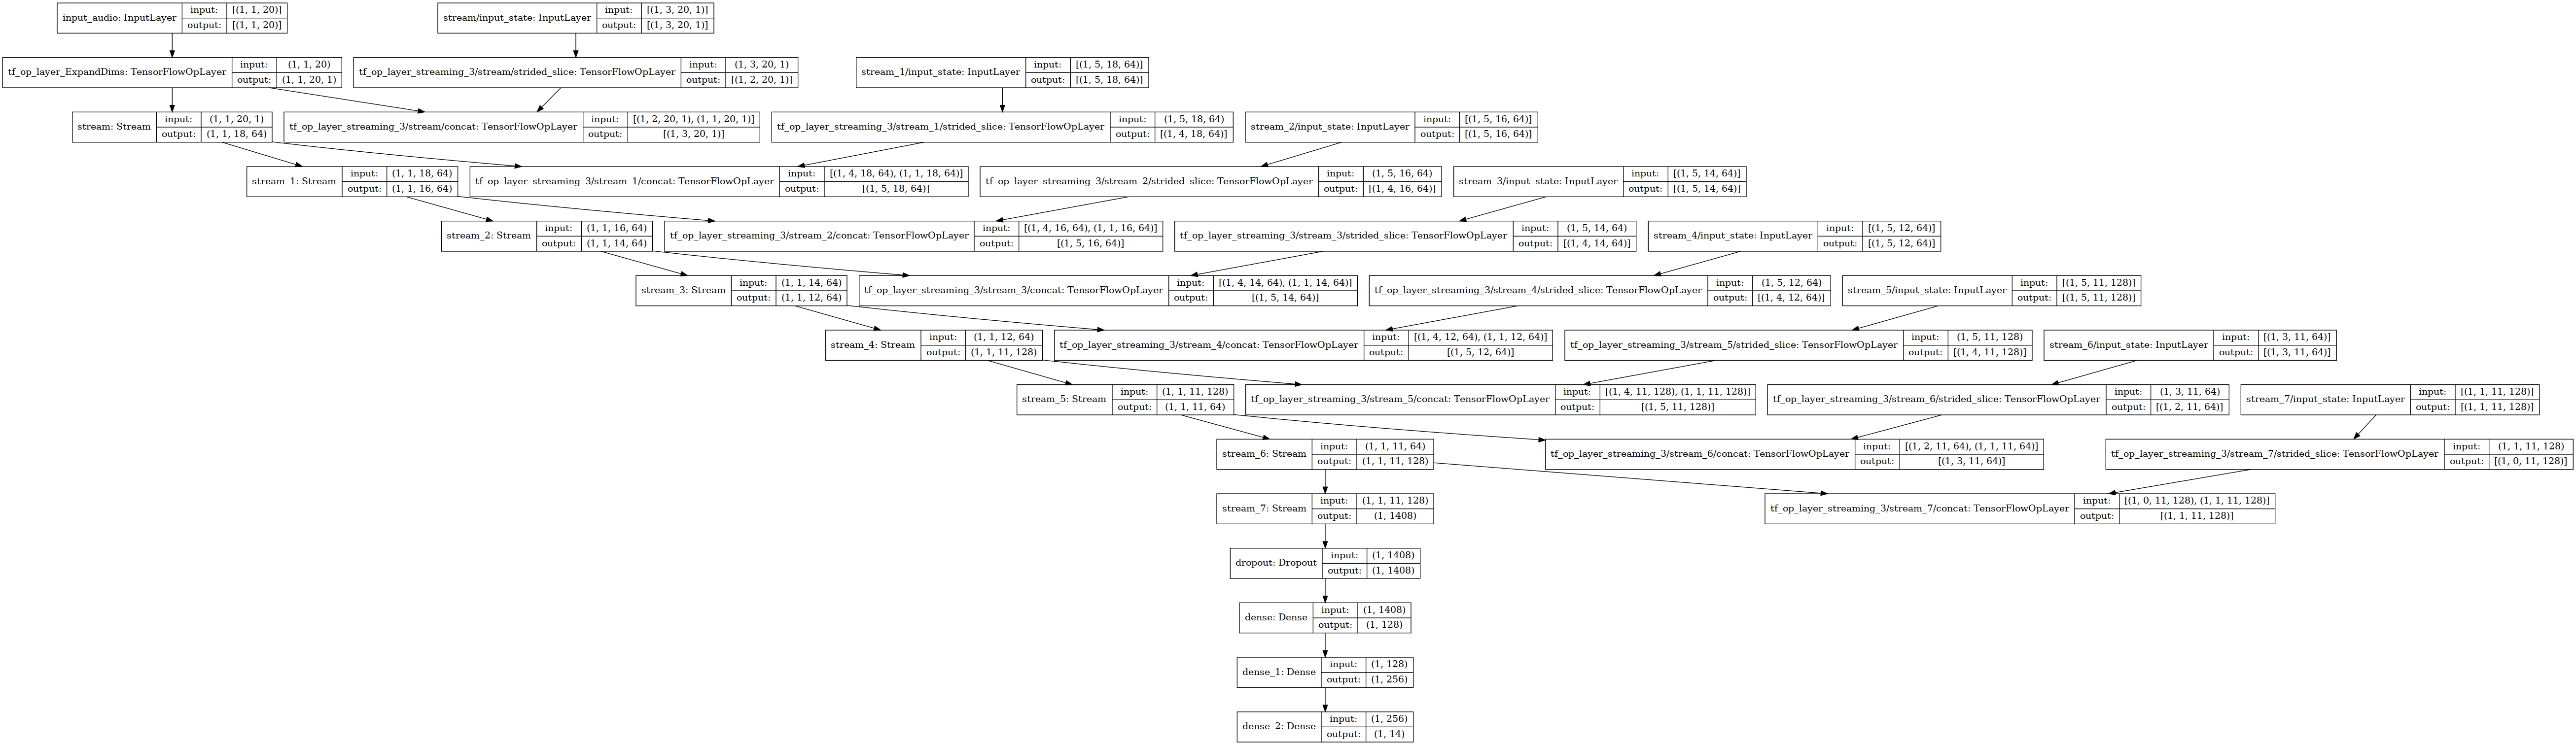

In [86]:
tf.keras.utils.plot_model(
    model_stream,
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True)

In [89]:
inputs = []
for s in range(len(model_stream.inputs)):
  inputs.append(np.zeros(model_stream.inputs[s].shape, dtype=np.float32))

reset_state = True

if reset_state:
  for s in range(len(model_stream.inputs)):
    inputs[s] = np.zeros(model_stream.inputs[s].shape, dtype=np.float32)

start = 0
end = flags.window_stride_samples if flags.preprocess not in {'mfcc', 'micro'} else 1
while end <= input_data.shape[1]:
  # get new frame from stream of data
  stream_update = input_data[:, start:end]

  # update indexes of streamed updates
  start = end
  end = start + flags.window_stride_samples  if flags.preprocess not in {'mfcc', 'micro'} else start + 1

  # set input audio data (by default input data at index 0)
  inputs[0] = stream_update

  # run inference
  outputs = model_stream.predict(inputs, steps=1)

  # get output states and set it back to input states
  # which will be fed in the next inference cycle
  for s in range(1, len(model_stream.inputs)):
    inputs[s] = outputs[s]

  stream_output_arg = np.argmax(outputs[0])
  print(stream_output_arg)
stream_output_arg

5
5
2
2
1
10
10
10
10
1
1
1
1
1
1
1
1
1
1
1
1
13
13
13
13


13

In [ ]:
index_to_label[stream_output_arg]

## Run inference with TFlite

### Run non streaming inference with TFLite

In [90]:
# path = os.path.join(train_dir, 'tflite_non_stream')
# tflite_model_name = 'non_stream.tflite'

tflite_non_streaming_model = utils.model_to_tflite(sess, model_non_stream, flags, Modes.NON_STREAM_INFERENCE)

Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`


Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`


Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


INFO:tensorflow:Froze 20 variables.


INFO:tensorflow:Froze 20 variables.


INFO:tensorflow:Converted 20 variables to const ops.


INFO:tensorflow:Converted 20 variables to const ops.


In [155]:
# prepare TFLite interpreter
# with tf.io.gfile.Open(os.path.join(path, tflite_model_name), 'rb') as f:
#   model_content = f.read()

interpreter = tf.lite.Interpreter(model_content=tflite_non_streaming_model)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

inputs = []
for s in range(len(input_details)):
  inputs.append(np.zeros(input_details[s]['shape'], dtype=np.float32))
print(input_details[0]['shape'])
# print(input_details)
print(output_details)

[ 1 25 20]
[{'name': 'streaming_5/dense_2/BiasAdd', 'index': 34, 'shape': array([ 1, 14], dtype=int32), 'shape_signature': array([ 1, 14], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [132]:
if flags.preprocess in {'mfcc', 'micro'}:
    padded_input = np.zeros((1, 25, 10), dtype=np.float32)
else:
    padded_input = np.zeros((1, 16000), dtype=np.float32)
    padded_input[:, :input_data.shape[1]] = input_data

# convert tensor to numpy
padded_input = input_data.eval(session=sess)
padded_input.shape

(1, 25, 20)

In [133]:
# set input audio data (by default input data at index 0)
interpreter.set_tensor(input_details[0]['index'], padded_input)

# run inference
interpreter.invoke()

# get output: classification
out_tflite = interpreter.get_tensor(output_details[0]['index'])

out_tflite_argmax = np.argmax(out_tflite)

out_tflite_argmax

13

In [134]:
print(out_tflite)

[[-27.607685    -0.18104957  -1.1647539   -2.1733847   -4.641821
   -3.2083516   -3.5388737   -0.91739947  -7.645591    -6.339117
   -5.7886744   -4.265486     9.573342    25.582157  ]]


In [135]:
index_to_label[out_tflite_argmax]

'xrxr'

### Run streaming inference with TFLite

In [136]:
# path = os.path.join(train_dir, 'tflite_stream_state_external')
# tflite_model_name = 'stream_state_external.tflite'

tflite_streaming_model = utils.model_to_tflite(sess, model_non_stream, flags, Modes.STREAM_EXTERNAL_STATE_INFERENCE)

INFO:tensorflow:Froze 20 variables.


INFO:tensorflow:Froze 20 variables.


INFO:tensorflow:Converted 20 variables to const ops.


INFO:tensorflow:Converted 20 variables to const ops.


In [137]:
# with tf.io.gfile.Open(os.path.join(path, tflite_model_name), 'rb') as f:
#   model_content = f.read()

interpreter = tf.lite.Interpreter(model_content=tflite_streaming_model)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

inputs = []
for s in range(len(input_details)):
  inputs.append(np.zeros(input_details[s]['shape'], dtype=np.float32))

In [138]:
input_details[0]['shape']

array([ 1,  1, 20], dtype=int32)

In [141]:
reset_state = True

# before processing new test sequence we can reset model state
# if we reset model state then it is not real streaming mode
if reset_state:
  for s in range(len(input_details)):
    print(input_details[s]['shape'])
    inputs[s] = np.zeros(input_details[s]['shape'], dtype=np.float32)

start = 0
end = flags.window_stride_samples if flags.preprocess not in {'mfcc', 'micro'} else 1
while end <= input_data.shape[1]:
  stream_update = input_data[:, start:end]
  # convert tensor to numpy
  stream_update = stream_update.eval(session=sess)
  stream_update = stream_update.astype(np.float32)

  # update indexes of streamed updates
  start = end
  end = start + flags.window_stride_samples if flags.preprocess not \
                in {'mfcc', 'micro'} else start + 1

  # set input audio data (by default input data at index 0)
  interpreter.set_tensor(input_details[0]['index'], stream_update)

  # set input states (index 1...)
  for s in range(1, len(input_details)):
    interpreter.set_tensor(input_details[s]['index'], inputs[s])

  # run inference
  interpreter.invoke()

  # get output: classification
  out_tflite = interpreter.get_tensor(output_details[0]['index'])
  #print(start / 16000.0, np.argmax(out_tflite), np.max(out_tflite))

  # get output states and set it back to input states
  # which will be fed in the next inference cycle
  for s in range(1, len(input_details)):
    # The function `get_tensor()` returns a copy of the tensor data.
    # Use `tensor()` in order to get a pointer to the tensor.
    inputs[s] = interpreter.get_tensor(output_details[s]['index'])

  out_tflite_argmax = np.argmax(out_tflite)
out_tflite_argmax

[ 1  1 20]
[ 1  3 20  1]
[ 1  5 18 64]
[ 1  5 16 64]
[ 1  5 14 64]
[ 1  5 12 64]
[  1   5  11 128]
[ 1  3 11 64]
[  1   1  11 128]


13

In [142]:
print(out_tflite)

[[-27.60769     -0.18104897  -1.1647552   -2.173383    -4.641822
   -3.2083497   -3.5388765   -0.91740113  -7.64559     -6.3391166
   -5.788676    -4.265485     9.573346    25.582155  ]]


In [143]:
index_to_label[out_tflite_argmax]

'xrxr'